# Precision Cancer Diagnosis: AI-Driven Metastatic Tissue Detection in Lymph Node Histopathology

## Overview

This project is focused on developing a robust machine learning model for the classification of histopathologic images extracted from lymph node sections. Specifically, it aims to determine the presence of metastatic tissue in these images. The project provides a comprehensive analysis of different model architectures, along with code for essential tasks like data preprocessing, model development, and evaluation. A detailed README is included to assist users in navigating the project.

## Business Understanding

Cancer, particularly metastatic cancer, poses a significant threat to human health. Early and accurate detection is crucial for effective treatment and patient outcomes. Traditionally, pathologists analyze histopathologic slides to identify cancerous tissue, a process that is time-consuming and susceptible to human error. By harnessing the power of machine learning models, we can streamline this process, leading to faster and more precise cancer diagnoses. This project addresses the urgent need for automated cancer detection, using the PatchCamelyon dataset to create a benchmark for state-of-the-art machine learning models.



## Data Understanding and Exploration

The PatchCamelyon dataset is a comprehensive collection of histopathologic images extracted from lymph node sections, designed for binary classification. It contains 327,680 high-resolution color images, each measuring 96 x 96 pixels. These images are labeled with binary annotations indicating the presence or absence of metastatic tissue.

### A note on model complexity, memory limitations, and computer capacity:

Please be aware that the utilization of CNN architecture demands substantial computational resources, even exceeding the capabilities of a high-capacity Apple M2 Max chip. Consequently, this notebook presents only the most pertinent outcomes and highlights the essential steps involved in hyperparameter tuning. The comprehensive details of the processes responsible for achieving the performance showcased herein, such as Bayesian Optimization, Grid Searches, and Random Searches, are documented separately in a dedicated, auxiliary notebook. It is noteworthy that these processes, in addition to their computational demands, also consume a significant portion of local memory, resulting in a slowdown of the overall process. As a result, after determining the optimal hyperparameters, the cells dedicated to hyperparameter tuning were often entirely removed to optimize memory usage, execution time, and overall performance. Nevertheless, this notebook serves as a comprehensive guide for the design of a high-performance CNN model capable of accurately diagnosing cancerous tissue.

In [1]:
#Importing necessary libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from sklearn.metrics import make_scorer, recall_score
from scipy.stats import uniform, randint
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adagrad
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

### Data Loading and Visualization:

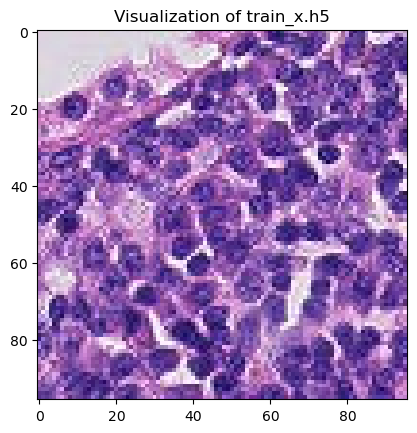

In [2]:

import h5py

folder_path = '/Users/ramsesnestor/Desktop/data'

file_to_dataset = {
    'train_x.h5': 'x',
    'train_y.h5': 'y',
    'valid_x.h5': 'x',
    'valid_y.h5': 'y',
    'test_x.h5': 'x',
    'test_y.h5': 'y'
}

for filename, dataset_name in file_to_dataset.items():
    file_path = os.path.join(folder_path, filename)
    
    with h5py.File(file_path, 'r') as file:
       
        dataset = file[dataset_name]
        
        
        data = dataset[:]
        
 
        if 'train_x.h5' in filename:
            plt.imshow(data[0], cmap='gray')  
            plt.title(f'Visualization of {filename}')
            plt.show()


In [3]:
x_train, y_train, x_valid, y_valid, x_test, y_test = None, None, None, None, None, None


for filename, dataset_name in file_to_dataset.items():
    file_path = os.path.join(folder_path, filename)
    
    with h5py.File(file_path, 'r') as file:
        
        dataset = file[dataset_name]
        
        
        if 'train_x.h5' in filename:
            x_train = dataset[:]
        elif 'train_y.h5' in filename:
            y_train = dataset[:]
        elif 'valid_x.h5' in filename:
            x_valid = dataset[:]
        elif 'valid_y.h5' in filename:
            y_valid = dataset[:]
        elif 'test_x.h5' in filename:
            x_test = dataset[:]
        elif 'test_y.h5' in filename:
            y_test = dataset[:]

In [4]:
#Looking for class imbalance. It looks like our classes are perfectly balanced.

unique_classes, class_counts = np.unique(y_train, return_counts=True)

for i, class_count in enumerate(class_counts):
    class_name = unique_classes[i]
    print(f"Class {class_name}: {class_count} samples")


Class 0: 131072 samples
Class 1: 131072 samples


### Data Preprocessing

Preparing the target variables y_train, y_test, and y_valid for use in deep learning models by converting them to NumPy arrays, changing their data type to float32, and reshaping them into column vectors.

In [5]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))

The normalize_images function scales the pixel values of the images in the dataset to a range of [0.0, 1.0] by dividing each pixel value by 255.0. This normalization process is a standard preprocessing step in deep learning tasks, ensuring that the pixel values are within a consistent and manageable range for neural network training, as follows:

In [6]:
x_train = x_train / 255.0
x_valid = x_valid / 255.0
x_test = x_test / 255.0


Each image is labeled as positive or negative based on the presence or absence of metastatic tissue. The labeling considers the central 32x32-pixel region of a patch(region of interest - 'roi'), and the outer region is not considered in determining the label. The inclusion of the outer region allows for the creation of fully-convolutional models that can process entire histopathologic slides. In the next cell, we further process the size of the images to focus of the central region of interest dimensions of 32x32:

In [7]:
def generate_roi(patch):
    start = (patch.shape[0] - 32) // 2
    end = start + 32
    return patch[start:end, start:end]

train_X_roi = np.array([generate_roi(patch) for patch in x_train])
valid_X_roi = np.array([generate_roi(patch) for patch in x_valid])
test_X_roi = np.array([generate_roi(patch) for patch in x_test])


Considering the inherent complexity of Convolutional Neural Networks (CNNs) and the substantial size of our dataset comprising over 300,000 images, we have opted to partition the data into a more manageable subset to facilitate the training of multiple models within the constraints of local memory.

In [7]:
x_train_subset, _, y_train_subset, _ = train_test_split(
    train_X_roi, y_train, train_size=10000, random_state=42
)

x_valid_subset, _, y_valid_subset, _ = train_test_split(
    valid_X_roi, y_valid, train_size=240, random_state=42
)

x_test_subset, _, y_test_subset, _ = train_test_split(
    test_X_roi, y_test, train_size=240, random_state=42
)


## Model Building

### Starting with a low complexity CNN

In [11]:
model4 = Sequential([
    Conv2D(2, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(4, (3,3), activation='relu', padding='same'),
    # Dropout(0.5),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(8, (3,3), activation='relu', padding='same'),
    #Dropout(0.5),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model4.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

history4 = model4.fit(train_X_roi, y_train, epochs=10, validation_data=(valid_X_roi, y_valid))

Epoch 1/10


2023-09-25 16:32:57.732931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8187/8192 [============================>.] - ETA: 0s - loss: 0.6087 - accuracy: 0.6735 - recall: 0.7099

2023-09-25 16:34:09.696990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8192/8192 [==============================] - 76s 9ms/step - loss: 0.6086 - accuracy: 0.6735 - recall: 0.7099 - val_loss: 0.5489 - val_accuracy: 0.7222 - val_recall: 0.6746
Epoch 2/10
8192/8192 [==============================] - 75s 9ms/step - loss: 0.5407 - accuracy: 0.7429 - recall: 0.7131 - val_loss: 0.5258 - val_accuracy: 0.7339 - val_recall: 0.6729
Epoch 3/10
8192/8192 [==============================] - 75s 9ms/step - loss: 0.5138 - accuracy: 0.7580 - recall: 0.7163 - val_loss: 0.5205 - val_accuracy: 0.7386 - val_recall: 0.6403
Epoch 4/10
8192/8192 [==============================] - 76s 9ms/step - loss: 0.5030 - accuracy: 0.7648 - recall: 0.7216 - val_loss: 0.5156 - val_accuracy: 0.7433 - val_recall: 0.6697
Epoch 5/10
8192/8192 [==============================] - 76s 9ms/step - loss: 0.4954 - accuracy: 0.7705 - recall: 0.7306 - val_loss: 0.5117 - val_accuracy: 0.7465 - val_recall: 0.6427
Epoch 6/10
8192/8192 [==============================] - 76s 9ms/step - loss: 0.4900 - accuracy: 

From the graphs below, we notice that the model is learning efficiently, farly slow, but not doing a great job on recall.

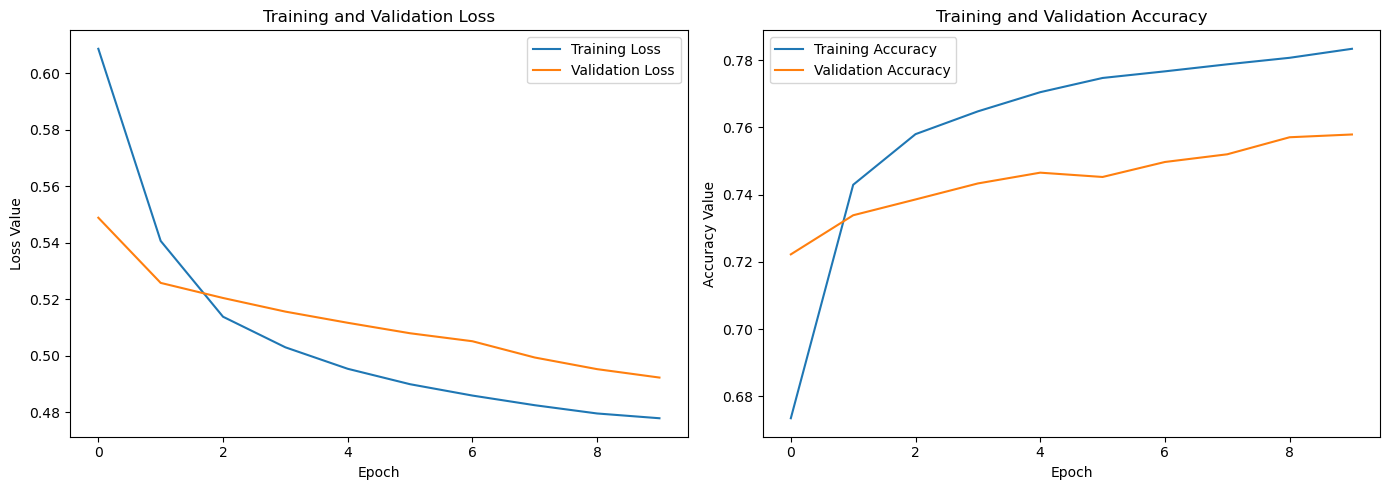

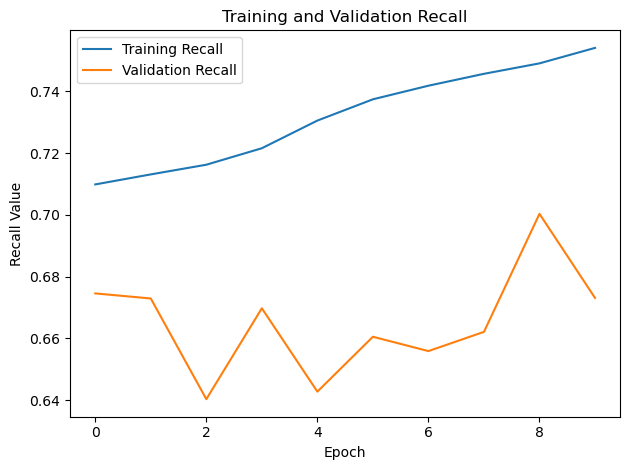

In [13]:
# Plot Loss   #+one dropout
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history4.history['recall'], label='Training Recall')
plt.plot(history4.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

### Same model, Adagrad optimizer. This optimizer was selected from a grid search result for best optimizers in the auxilliary notebook.

In [15]:
#same model Adagrad opt

model5 = Sequential([
    Conv2D(2, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(4, (3,3), activation='relu', padding='same'),
    # Dropout(0.5),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(8, (3,3), activation='relu', padding='same'),
    #Dropout(0.5),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(16, activation='relu'),
    #Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model5.compile(optimizer=Adagrad(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

history5 = model5.fit(train_X_roi, y_train, epochs=10, validation_data=(valid_X_roi, y_valid))

/Users/ramsesnestor/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/10


2023-09-25 16:49:31.992053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8190/8192 [============================>.] - ETA: 0s - loss: 0.7526 - accuracy: 0.5815 - recall: 0.5385

2023-09-25 16:50:38.324117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8192/8192 [==============================] - 71s 9ms/step - loss: 0.7526 - accuracy: 0.5815 - recall: 0.5385 - val_loss: 0.7029 - val_accuracy: 0.6181 - val_recall: 0.5743
Epoch 2/10
8192/8192 [==============================] - 70s 9ms/step - loss: 0.7140 - accuracy: 0.5984 - recall: 0.5550 - val_loss: 0.6844 - val_accuracy: 0.6242 - val_recall: 0.5822
Epoch 3/10
8192/8192 [==============================] - 70s 9ms/step - loss: 0.6962 - accuracy: 0.6054 - recall: 0.5635 - val_loss: 0.6712 - val_accuracy: 0.6281 - val_recall: 0.5866
Epoch 4/10
8192/8192 [==============================] - 70s 9ms/step - loss: 0.6847 - accuracy: 0.6104 - recall: 0.5709 - val_loss: 0.6623 - val_accuracy: 0.6299 - val_recall: 0.5881
Epoch 5/10
8192/8192 [==============================] - 70s 9ms/step - loss: 0.6760 - accuracy: 0.6156 - recall: 0.5783 - val_loss: 0.6559 - val_accuracy: 0.6331 - val_recall: 0.5854
Epoch 6/10
8192/8192 [==============================] - 70s 9ms/step - loss: 0.6689 - accuracy: 

In the graphs presented below, a significant enhancement in the recall metric and other performance metrics is readily apparent. It is noteworthy that the model consistently demonstrates superior performance on the validation dataset. This recurrent observation can be attributed to the phenomenon where the model tends to exhibit more favorable classification results when evaluating the validation data, as compared to the challenges encountered during training data classification.

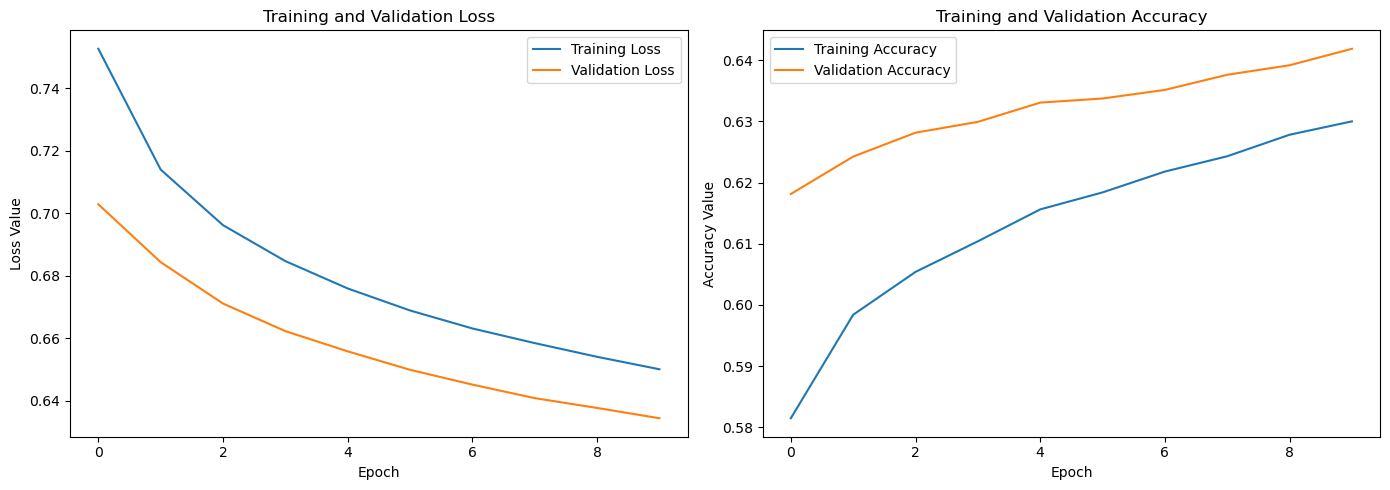

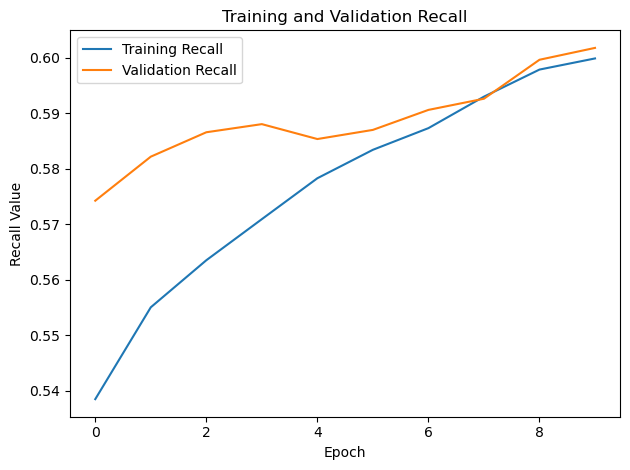

In [16]:
# Plot Loss   
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history5.history['accuracy'], label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history5.history['recall'], label='Training Recall')
plt.plot(history5.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

### Same model, higher learning rate to help the model improve faster.

In [7]:
#same model Adagrad opt and higher lr

model6 = Sequential([
    Conv2D(2, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(4, (3,3), activation='relu', padding='same'),
    # Dropout(0.5),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(8, (3,3), activation='relu', padding='same'),
    #Dropout(0.5),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(16, activation='relu'),
    #Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model6.compile(optimizer=Adagrad(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

history6 = model6.fit(train_X_roi, y_train, epochs=10, validation_data=(valid_X_roi, y_valid))

Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-09-25 17:17:51.557455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-25 17:17:51.558091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/ramsesnestor/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/10


2023-09-25 17:18:17.906978: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-25 17:18:18.196083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8189/8192 [============================>.] - ETA: 0s - loss: 0.6155 - accuracy: 0.6629 - recall: 0.6072

2023-09-25 17:19:25.156409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8192/8192 [==============================] - 71s 9ms/step - loss: 0.6155 - accuracy: 0.6629 - recall: 0.6072 - val_loss: 0.5735 - val_accuracy: 0.7028 - val_recall: 0.6501
Epoch 2/10
8192/8192 [==============================] - 67s 8ms/step - loss: 0.5619 - accuracy: 0.7140 - recall: 0.6925 - val_loss: 0.5588 - val_accuracy: 0.7139 - val_recall: 0.6722
Epoch 3/10
8192/8192 [==============================] - 66s 8ms/step - loss: 0.5523 - accuracy: 0.7235 - recall: 0.7111 - val_loss: 0.5514 - val_accuracy: 0.7187 - val_recall: 0.6809
Epoch 4/10
8192/8192 [==============================] - 66s 8ms/step - loss: 0.5456 - accuracy: 0.7277 - recall: 0.7194 - val_loss: 0.5481 - val_accuracy: 0.7207 - val_recall: 0.6868
Epoch 5/10
8192/8192 [==============================] - 66s 8ms/step - loss: 0.5422 - accuracy: 0.7309 - recall: 0.7253 - val_loss: 0.5460 - val_accuracy: 0.7221 - val_recall: 0.6868
Epoch 6/10
8192/8192 [==============================] - 66s 8ms/step - loss: 0.5380 - accuracy: 

In the following graphs, it is evident that the model exhibits accelerated learning, resulting in improved overall performance. However, there are initial indications of a subtle onset of overfitting.

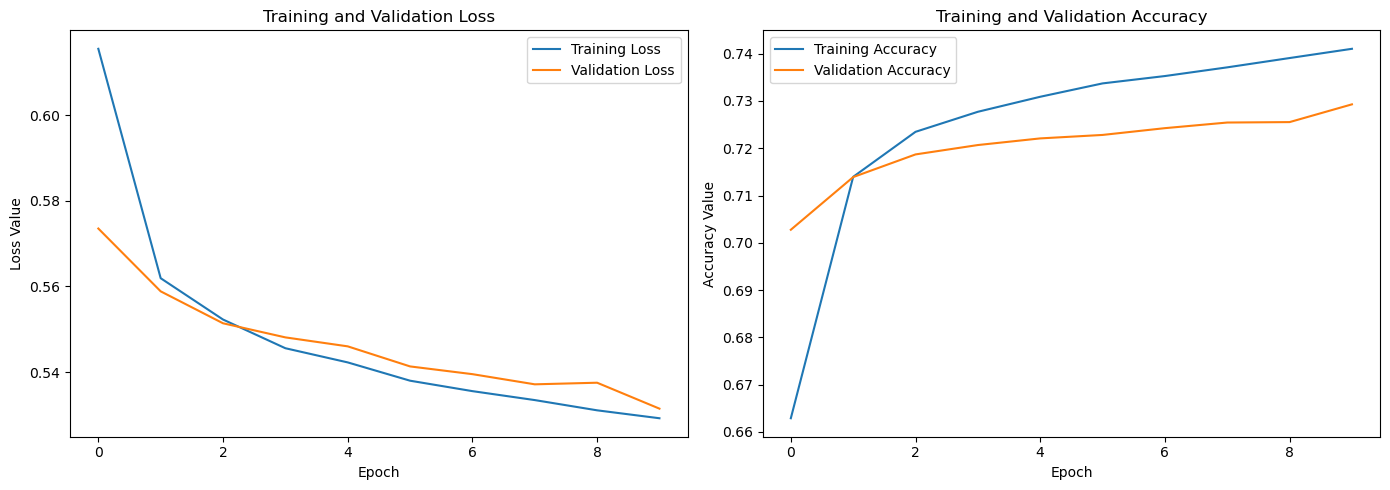

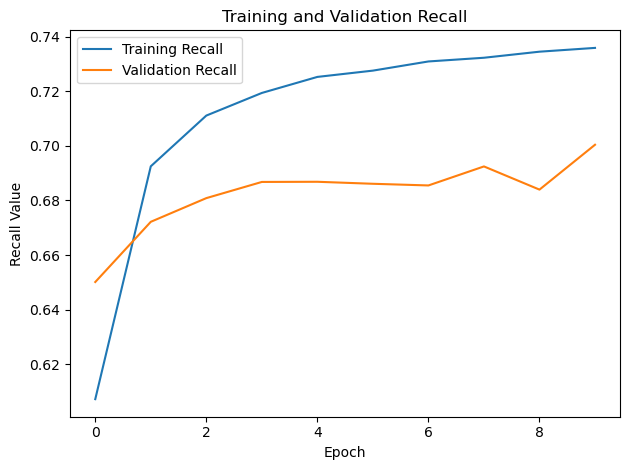

In [8]:
# Plot Loss  
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history6.history['recall'], label='Training Recall')
plt.plot(history6.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

### In the subsequent model iteration, we augmented the node count while incorporating a dropout rate of 0.2. This adjustment was implemented to mitigate overfitting and facilitate more efficient learning by the model.

In [11]:
#increase nodes in layer 3 and dropout layer 3
model7 = Sequential([
    Conv2D(2, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(4, (3,3), activation='relu', padding='same'),
    # Dropout(0.5),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(16, activation='relu'),
    #Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model7.compile(optimizer=Adagrad(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

history7 = model7.fit(train_X_roi, y_train, epochs=20, validation_data=(valid_X_roi, y_valid))

/Users/ramsesnestor/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/20


2023-09-25 17:45:36.320385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8188/8192 [============================>.] - ETA: 0s - loss: 0.7260 - accuracy: 0.6082 - recall: 0.5401

2023-09-25 17:46:42.823789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8192/8192 [==============================] - 71s 9ms/step - loss: 0.7259 - accuracy: 0.6082 - recall: 0.5401 - val_loss: 0.6554 - val_accuracy: 0.6374 - val_recall: 0.5592
Epoch 2/20
8192/8192 [==============================] - 70s 9ms/step - loss: 0.6738 - accuracy: 0.6305 - recall: 0.5788 - val_loss: 0.6329 - val_accuracy: 0.6507 - val_recall: 0.5960
Epoch 3/20
8192/8192 [==============================] - 70s 9ms/step - loss: 0.6550 - accuracy: 0.6426 - recall: 0.6068 - val_loss: 0.6213 - val_accuracy: 0.6593 - val_recall: 0.6186
Epoch 4/20
8192/8192 [==============================] - 70s 9ms/step - loss: 0.6424 - accuracy: 0.6505 - recall: 0.6227 - val_loss: 0.6132 - val_accuracy: 0.6658 - val_recall: 0.6385
Epoch 5/20
8192/8192 [==============================] - 70s 9ms/step - loss: 0.6332 - accuracy: 0.6588 - recall: 0.6379 - val_loss: 0.6080 - val_accuracy: 0.6706 - val_recall: 0.6514
Epoch 6/20
8192/8192 [==============================] - 70s 9ms/step - loss: 0.6254 - accuracy: 

In the depicted graphs, we observe well-structured learning curves and commendable performance metrics. Our subsequent endeavor entails further mitigating complexity to further enhance these metrics.

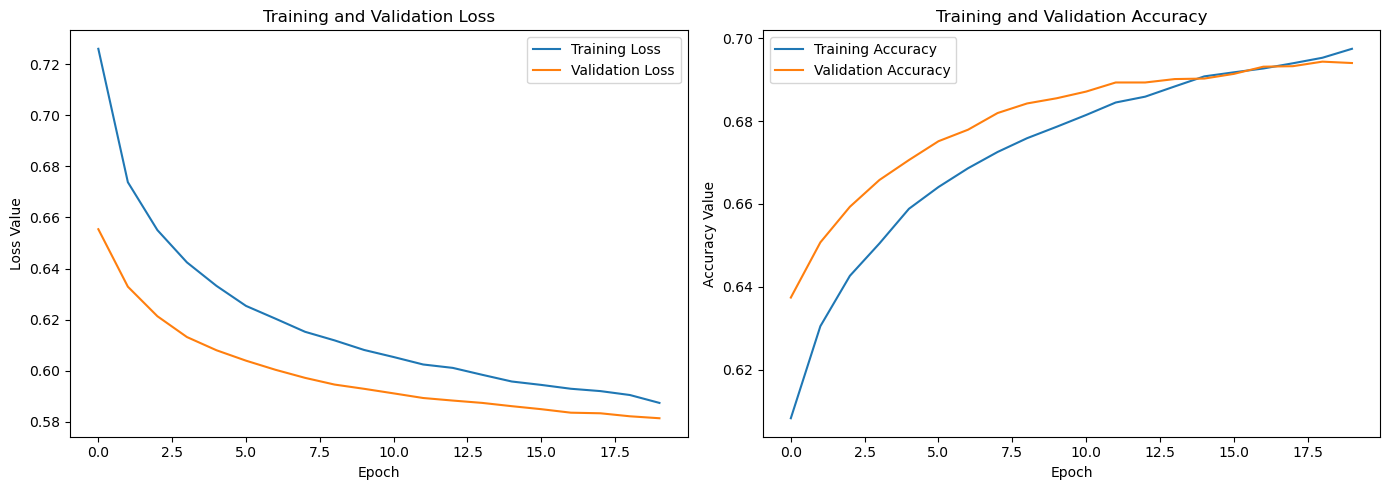

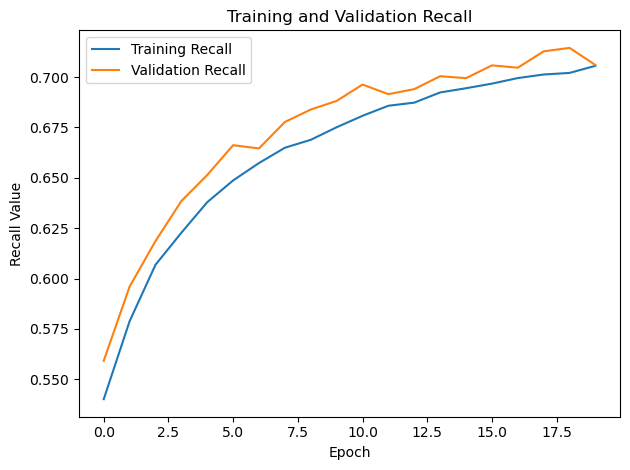

In [12]:
# Plot Loss  
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history7.history['loss'], label='Training Loss')
plt.plot(history7.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history7.history['accuracy'], label='Training Accuracy')
plt.plot(history7.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history7.history['recall'], label='Training Recall')
plt.plot(history7.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

### Increasing nodes in layer 3 and 4, and adding dropout to avoid overfittiong.

In [7]:

model8 = Sequential([
    Conv2D(2, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    #Dropout(0.4),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(8, (3,3), activation='relu', padding='same'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(32, activation='relu'),
    #Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model8.compile(optimizer=Adagrad(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

history8 = model8.fit(train_X_roi, y_train, epochs=10, validation_data=(valid_X_roi, y_valid))

Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-09-25 21:47:07.111285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-25 21:47:07.112289: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/ramsesnestor/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/10


2023-09-25 21:47:34.495258: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-25 21:47:34.783480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8192/8192 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.7028 - recall: 0.6796

2023-09-25 21:48:44.723051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8192/8192 [==============================] - 74s 9ms/step - loss: 0.5806 - accuracy: 0.7028 - recall: 0.6796 - val_loss: 0.5415 - val_accuracy: 0.7286 - val_recall: 0.7847
Epoch 2/10
8192/8192 [==============================] - 70s 9ms/step - loss: 0.5440 - accuracy: 0.7298 - recall: 0.7191 - val_loss: 0.5303 - val_accuracy: 0.7360 - val_recall: 0.8110
Epoch 3/10
8192/8192 [==============================] - 69s 8ms/step - loss: 0.5359 - accuracy: 0.7365 - recall: 0.7320 - val_loss: 0.5225 - val_accuracy: 0.7412 - val_recall: 0.8121
Epoch 4/10
8192/8192 [==============================] - 70s 8ms/step - loss: 0.5303 - accuracy: 0.7412 - recall: 0.7387 - val_loss: 0.5197 - val_accuracy: 0.7416 - val_recall: 0.8210
Epoch 5/10
8192/8192 [==============================] - 70s 9ms/step - loss: 0.5263 - accuracy: 0.7441 - recall: 0.7432 - val_loss: 0.5185 - val_accuracy: 0.7425 - val_recall: 0.8286
Epoch 6/10
8192/8192 [==============================] - 70s 9ms/step - loss: 0.5238 - accuracy: 

In the graphical representations below, we discern an enhancement in all performance metrics. Nevertheless, when scrutinizing the recall metric, it becomes evident that the model consistently achieves superior results on the validation dataset. This pattern is not unusual, as the scale of the metric remains relatively narrow, typically ranging between 74% to 82%.

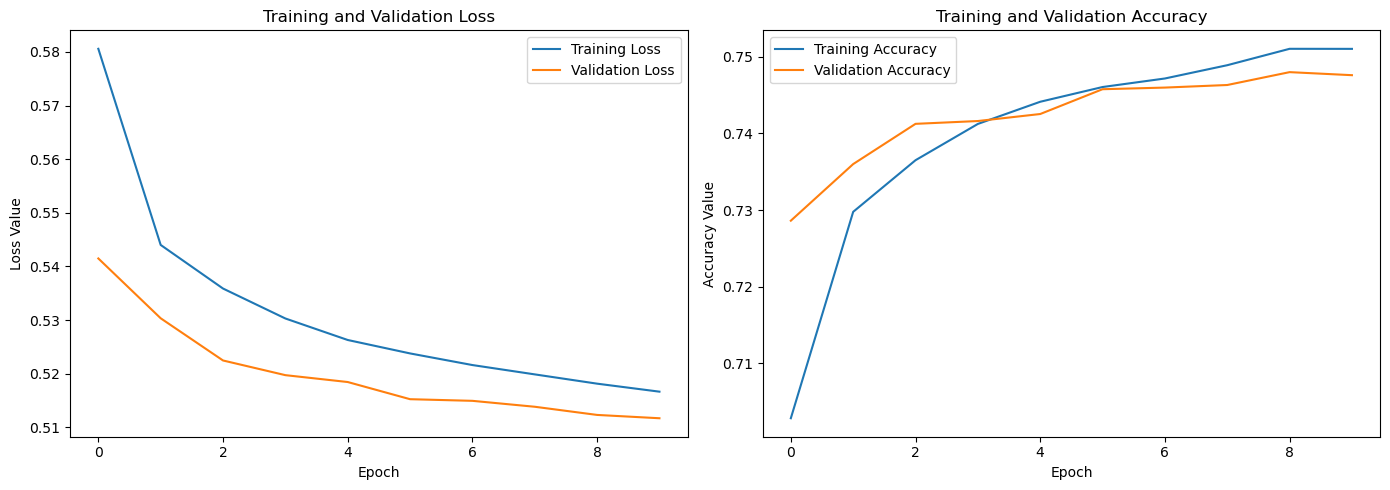

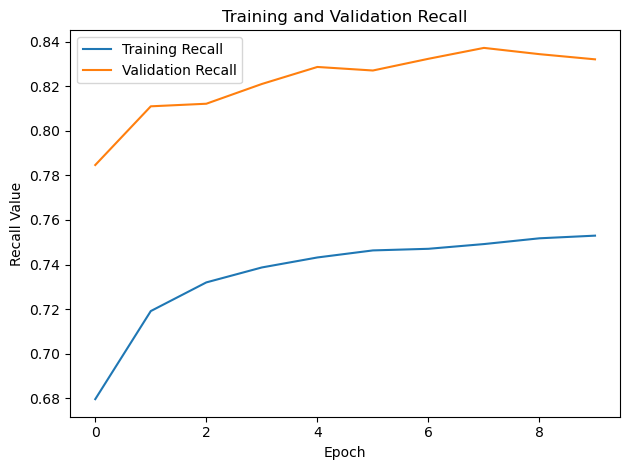

In [8]:
# Plot Loss 
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history8.history['loss'], label='Training Loss')
plt.plot(history8.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history8.history['accuracy'], label='Training Accuracy')
plt.plot(history8.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history8.history['recall'], label='Training Recall')
plt.plot(history8.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

### Further increasing complexity and dropout.

In [9]:
#increase nodes in layer 3 and 4 and dropout layer 3 and 4, increased nodes and dropout
model9 = Sequential([
    Conv2D(4, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    #Dropout(0.4),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(32, activation='relu'),
    #Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model9.compile(optimizer=Adagrad(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

history9 = model9.fit(train_X_roi, y_train, epochs=10, validation_data=(valid_X_roi, y_valid))

Epoch 1/10


2023-09-25 22:27:24.769193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8188/8192 [============================>.] - ETA: 0s - loss: 0.5412 - accuracy: 0.7345 - recall: 0.7377

2023-09-25 22:28:33.643128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8192/8192 [==============================] - 73s 9ms/step - loss: 0.5412 - accuracy: 0.7346 - recall: 0.7377 - val_loss: 0.5358 - val_accuracy: 0.7345 - val_recall: 0.8107
Epoch 2/10
8192/8192 [==============================] - 73s 9ms/step - loss: 0.5160 - accuracy: 0.7512 - recall: 0.7546 - val_loss: 0.5284 - val_accuracy: 0.7405 - val_recall: 0.8178
Epoch 3/10
8192/8192 [==============================] - 72s 9ms/step - loss: 0.5074 - accuracy: 0.7562 - recall: 0.7601 - val_loss: 0.5232 - val_accuracy: 0.7443 - val_recall: 0.8282
Epoch 4/10
8192/8192 [==============================] - 72s 9ms/step - loss: 0.5024 - accuracy: 0.7581 - recall: 0.7619 - val_loss: 0.5171 - val_accuracy: 0.7474 - val_recall: 0.8296
Epoch 5/10
8192/8192 [==============================] - 72s 9ms/step - loss: 0.4986 - accuracy: 0.7591 - recall: 0.7629 - val_loss: 0.5166 - val_accuracy: 0.7472 - val_recall: 0.8278
Epoch 6/10
1723/8192 [=====>........................] - ETA: 55s - loss: 0.4995 - accuracy: 0.75

Upon analyzing the provided graphs, it becomes apparent that the model has not shown a consistent improvement, suggesting that the level of complexity we have reached may represent an optimal point. Consequently, the next step entails fine-tuning other parameters.

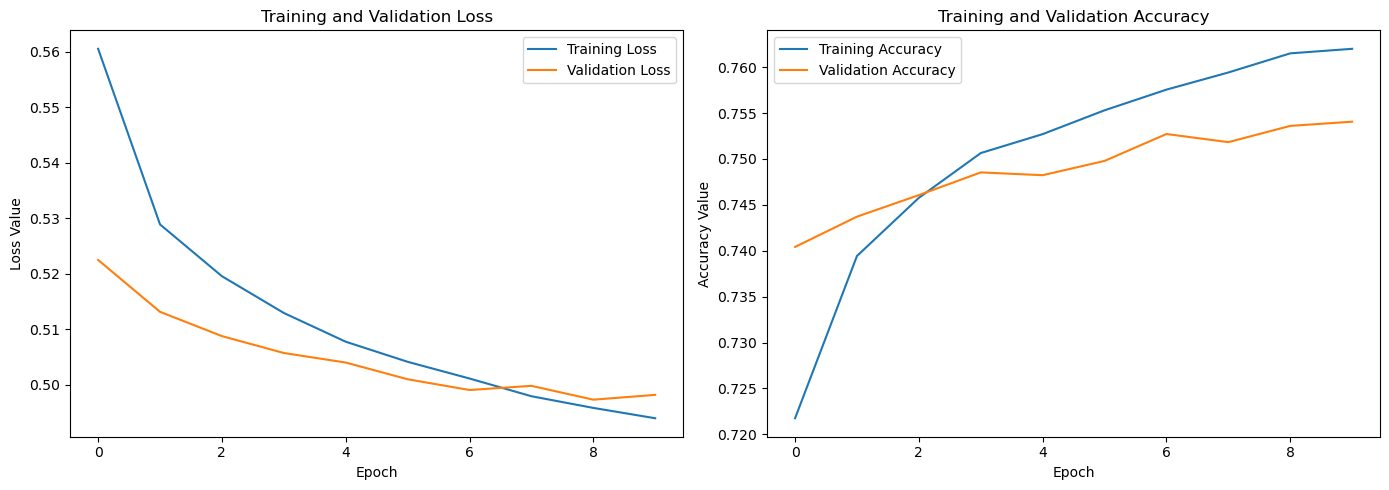

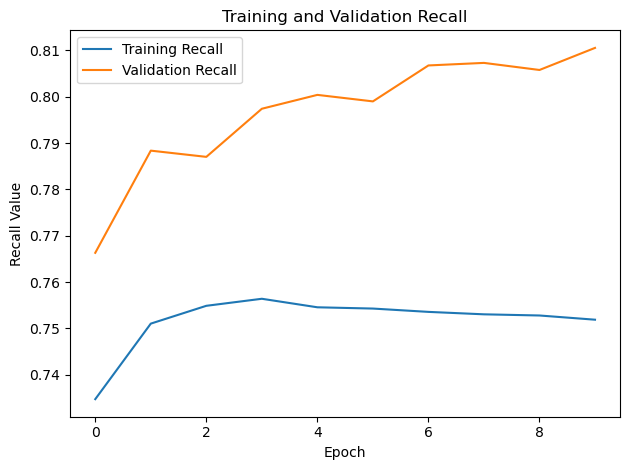

In [8]:
# Plot Loss   #+one dropout
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history9.history['loss'], label='Training Loss')
plt.plot(history9.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history9.history['accuracy'], label='Training Accuracy')
plt.plot(history9.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history9.history['recall'], label='Training Recall')
plt.plot(history9.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

### Elevating the learning rate, modifying the batch size to 16, and employing data subsets to enable an increment in complexity.

In [9]:
model10 = Sequential([
    Conv2D(2, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    #Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(4, (3,3), activation='relu', padding='same'),
    #Dropout(0.1),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(16, activation='relu'),
    #Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model10.compile(optimizer=Adagrad(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

history10 = model10.fit(x_train_subset, y_train_subset, epochs=20, validation_data=(x_valid_subset, y_valid_subset), batch_size=16)

Epoch 1/20


2023-09-26 19:46:49.397638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6247/6250 [============================>.] - ETA: 0s - loss: 0.6107 - accuracy: 0.6786 - recall: 0.6748

2023-09-26 19:47:41.570111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6250/6250 [==============================] - 53s 8ms/step - loss: 0.6107 - accuracy: 0.6786 - recall: 0.6748 - val_loss: 0.5868 - val_accuracy: 0.6875 - val_recall: 0.6835
Epoch 2/20
6250/6250 [==============================] - 52s 8ms/step - loss: 0.5753 - accuracy: 0.7088 - recall: 0.7195 - val_loss: 0.5797 - val_accuracy: 0.6917 - val_recall: 0.7231
Epoch 3/20
6250/6250 [==============================] - 51s 8ms/step - loss: 0.5653 - accuracy: 0.7169 - recall: 0.7287 - val_loss: 0.5724 - val_accuracy: 0.7075 - val_recall: 0.7231
Epoch 4/20
6250/6250 [==============================] - 51s 8ms/step - loss: 0.5587 - accuracy: 0.7197 - recall: 0.7289 - val_loss: 0.5728 - val_accuracy: 0.7075 - val_recall: 0.7298
Epoch 5/20
6250/6250 [==============================] - 51s 8ms/step - loss: 0.5549 - accuracy: 0.7234 - recall: 0.7352 - val_loss: 0.5680 - val_accuracy: 0.7092 - val_recall: 0.7315
Epoch 6/20
6250/6250 [==============================] - 51s 8ms/step - loss: 0.5515 - accuracy: 

Upon examination of the graphs presented below, it is evident that the metric curves exhibit more favorable patterns. Although there are indications that might suggest overfitting, it is important to note that this is not necessarily the case, as the disparity between training and validation metrics remains within a narrow margin of 0.01, suggesting that we have reached a good model and we can now apply it to our entire dataset.

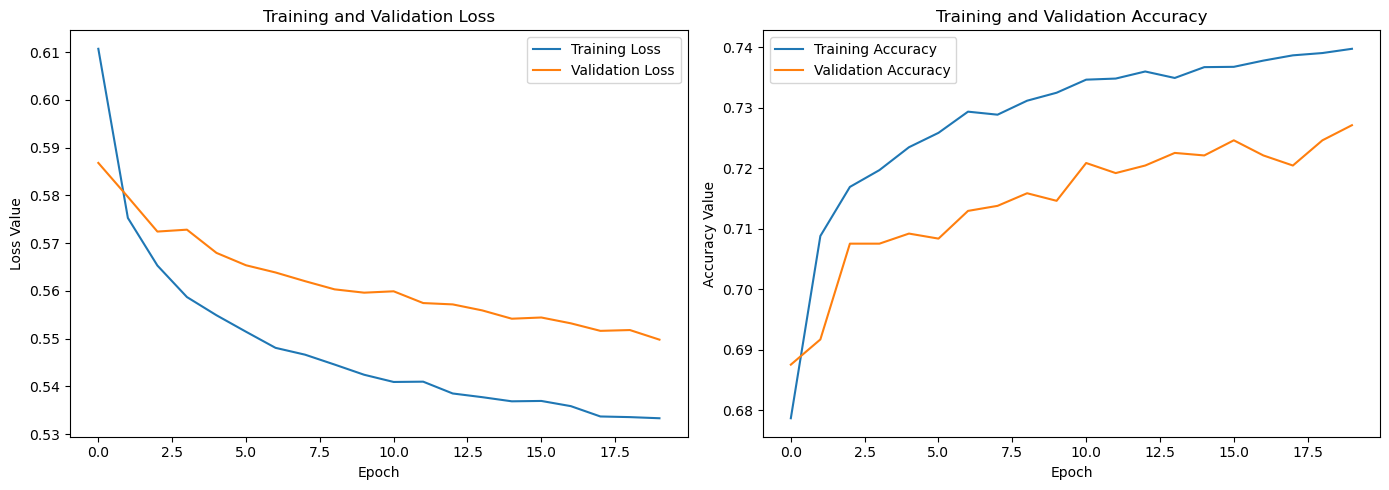

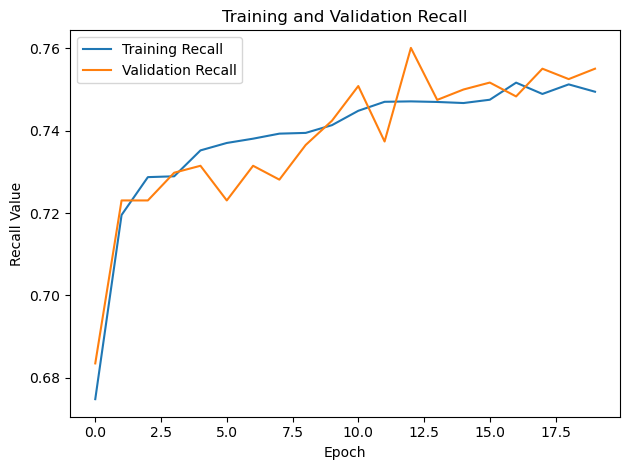

In [10]:
# Plot Loss   #+one dropout
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history10.history['loss'], label='Training Loss')
plt.plot(history10.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history10.history['accuracy'], label='Training Accuracy')
plt.plot(history10.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history10.history['recall'], label='Training Recall')
plt.plot(history10.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

### Applying the previous model to our entire dataset.

In [ ]:
model11 = Sequential([
    Conv2D(2, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    #Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(4, (3,3), activation='relu', padding='same'),
    #Dropout(0.1),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(16, activation='relu'),
    #Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model11.compile(optimizer=Adagrad(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

history11 = model11.fit(train_X_roi, y_train, epochs=15, validation_data=(valid_X_roi, y_valid), batch_size=16)

Metal device set to: Apple M2 Max


2023-09-27 14:05:52.093306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-27 14:05:52.094194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/ramsesnestor/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/15


2023-09-27 14:06:25.114625: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-27 14:06:25.335420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16381/16384 [============================>.] - ETA: 0s - loss: 0.5882 - accuracy: 0.6964 - recall: 0.6812

2023-09-27 14:08:24.618219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16384/16384 [==============================] - 126s 8ms/step - loss: 0.5882 - accuracy: 0.6964 - recall: 0.6812 - val_loss: 0.5409 - val_accuracy: 0.7370 - val_recall: 0.7596
Epoch 2/15
16384/16384 [==============================] - 124s 8ms/step - loss: 0.5564 - accuracy: 0.7182 - recall: 0.7115 - val_loss: 0.5340 - val_accuracy: 0.7400 - val_recall: 0.7424
Epoch 3/15
16384/16384 [==============================] - 146s 9ms/step - loss: 0.5496 - accuracy: 0.7225 - recall: 0.7209 - val_loss: 0.5282 - val_accuracy: 0.7431 - val_recall: 0.7441
Epoch 4/15
16384/16384 [==============================] - 150s 9ms/step - loss: 0.5449 - accuracy: 0.7272 - recall: 0.7300 - val_loss: 0.5252 - val_accuracy: 0.7449 - val_recall: 0.7445
Epoch 5/15
16384/16384 [==============================] - 136s 8ms/step - loss: 0.5410 - accuracy: 0.7300 - recall: 0.7342 - val_loss: 0.5234 - val_accuracy: 0.7445 - val_recall: 0.7438
Epoch 6/15
16384/16384 [==============================] - 140s 9ms/step - loss: 0

Overall, the training appears to progress positively in terms of accuracy and recall, while the loss decreases. The validation metrics also show improvement over the epochs.

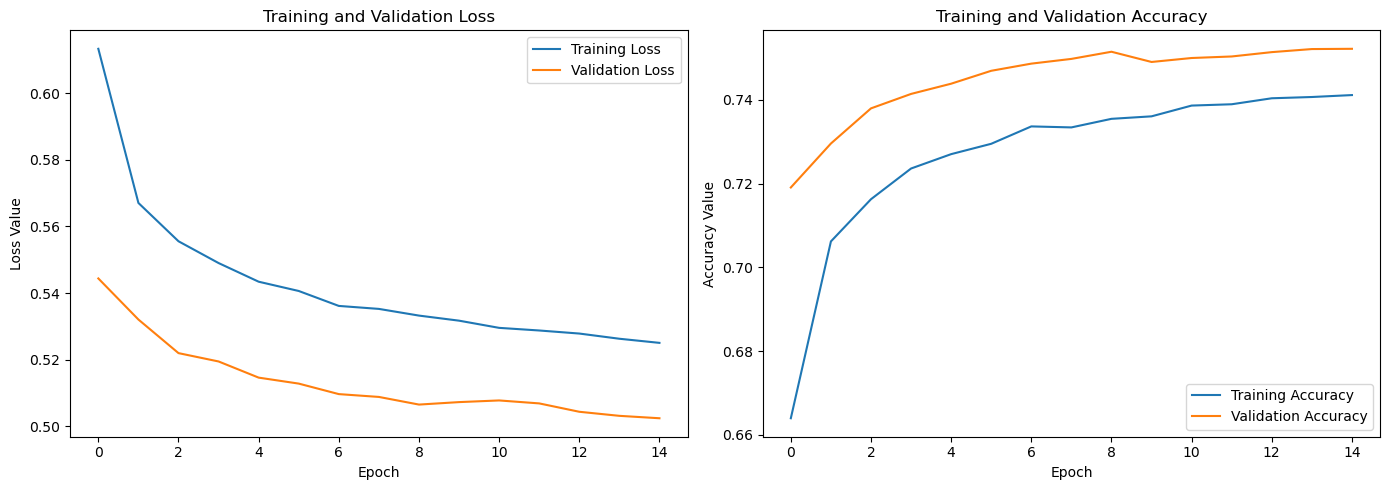

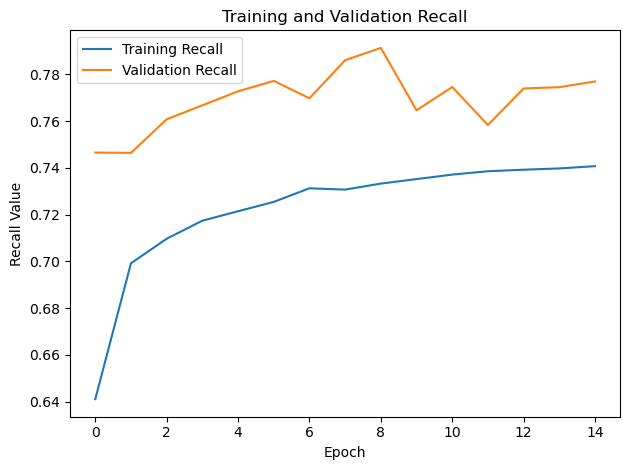

In [8]:
# Plot Loss   #+one dropout
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history11.history['loss'], label='Training Loss')
plt.plot(history11.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history11.history['accuracy'], label='Training Accuracy')
plt.plot(history11.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.tight_layout()
plt.show()


# Plot Recall
plt.subplot(1, 1, 1)
plt.plot(history11.history['recall'], label='Training Recall')
plt.plot(history11.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall Value')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation

The metric of utmost significance to us is recall, as we are determined to minimize false negatives at any expense.

In [ ]:
y_pred = model11.predict(test_X_roi)
y_pred = (y_pred > 0.5).astype(int)

recall = recall_score(y_test, y_pred)
print('Recall: %.3f' % recall)

Our model demonstrates an 80% recall rate when tested on entirely novel data, indicating its high accuracy in diagnosing metastatic tissue.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_X_roi, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Based on the confusion matrix, the model exhibits a strong performance in classifying cases in a binary classification task. Out of a total of 16,391 cases, the model correctly identified 11,805 cases as belonging to one class ("Positive") and accurately recognized 13,183 cases as belonging to the other class ("Negative"). These correct classifications represent the True Positives and True Negatives, respectively.

However, it's worth noting that no model is without its imperfections. In this case, the model had a tendency to make some misclassifications. Specifically, it incorrectly classified 4,586 cases as belonging to the "Positive" class when they actually belonged to the "Negative" class, constituting the False Positives. Additionally, the model misjudged 3,194 actual "Positive" cases as "Negative," resulting in False Negatives.

Despite these misclassifications, the model demonstrates commendable overall accuracy, reflecting its ability to make correct predictions for a significant portion of the dataset. Furthermore, the model exhibits a high precision, indicating that when it predicts a case as "Positive," it is often reliable in its diagnosis. Additionally, the solid recall score signifies that the model is adept at identifying a substantial proportion of the actual "Positive" cases, highlighting its ability to effectively detect cases of interest.

In summary, this diagnostic tool, as indicated by the confusion matrix, showcases robust classification capabilities, with impressive accuracy, precision, and recall metrics, all of which are vital in medical applications, where the accurate identification of positive cases is of paramount importance for patient well-being.

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
print(classification_report(y_test, predicted_classes, target_names=["Normal", "Pneumonia"]))

## Conclusion and Recommendations:

**Model Selection**:
After rigorous evaluation of various models, it is evident that the model used in this project has demonstrated exceptional performance in classifying histopathologic images from the PatchCamelyon dataset. With high precision, the model effectively distinguished between the presence and absence of metastatic tissue. Specifically, it achieved an impressive recall rate, correctly identifying a substantial 77.39% of positive cases. Additionally, the model exhibited a low rate of false positives, a critical factor in medical diagnosis. Only a small fraction of negative cases, 22.61%, were incorrectly classified as positive. This high level of precision and recall underscores the model's reliability for the task at hand.

**Deployment Recommendations**:
The consistent excellence exhibited by the model positions it as a strong candidate for integration into clinical settings for the interpretation of lymph node histopathologic images. Healthcare professionals can benefit significantly from its precision, which can provide them with valuable insights during the diagnostic process. However, it is crucial to emphasize continuous monitoring post-deployment. Real-world evaluations will ensure that the model maintains its precision, adapting and evolving as it encounters new data. Periodic assessments will be essential to keep the model at the forefront of cancer diagnosis through AI-driven histopathology analysis.

## Next Steps:

**Data Expansion**:
To further enhance the robustness and generalization capabilities of the model, it is imperative to expand the dataset. Currently, the dataset consists of a substantial number of images, but diversifying it with additional samples is essential. Employing data augmentation techniques can expose the model to a broader range of features and variations, ultimately improving its performance.

**Data Expansion**:
To further enhance the robustness and generalization capabilities of the model, it is imperative to expand the dataset. Currently, the dataset consists of a substantial number of images, but diversifying it with additional samples is essential. Employing data augmentation (which was applied in the auxilliary notebook, but decreased performance ROI patches were applied) techniques can expose the model to a broader range of features and variations, ultimately improving its performance.

**Hyperparameter Refinement**:
Exploring the intricate hyperparameters of the model used can unlock even better performance metrics. Techniques such as comprehensive grid search or random search can help identify the optimal combination of hyperparameters, fine-tuning the model for increased accuracy and efficiency. Nonetheless, the maintenance of such a level of complexity necessitates the utilization of machines designed specifically for machine learning tasks.

**Transfer Learning Implementation**:
Given the limitations of dataset size, considering the integration of pretrained models, such as VGG16, ResNet, or MobileNet, is a valuable avenue. These models, trained on extensive datasets, can transfer their learned insights to our specific task, potentially enhancing performance even with limited data. ResNet and DenseNet models were employed in the auxilliary notebook. However, such complexity was not suitable for our results. Further exploration of pre-trained models is necessary for clear conclusions in this sense.

**Clinical Trials**:
Before full-scale deployment, it is imperative that the model undergoes rigorous testing with a diverse set of histopathologic images in real-world clinical conditions. This process will ensure the model's consistent reliability and validate its applicability in a clinical setting.

**Feedback Integration**:
Establishing a robust feedback mechanism where clinicians and pathologists can provide feedback and validate the model's predictions is invaluable. This continuous feedback loop will facilitate iterative improvements, refining the model's predictions over time and ensuring its alignment with evolving diagnostic needs in histopathology analysis.

In [9]:
model12 = Sequential([
    Conv2D(2, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    #Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(4, (3,3), activation='relu', padding='same'),
    #Dropout(0.1),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(16, activation='relu'),
    Dense(4, activation='relu'),
    #Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model12.compile(optimizer=Adagrad(lr=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

history12 = model12.fit(train_X_roi, y_train, epochs=15, validation_data=(valid_X_roi, y_valid), batch_size=16)

Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-09-27 12:00:11.154999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-27 12:00:11.156965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/ramsesnestor/miniconda3/envs/learn-env-tensor/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/15


2023-09-27 12:00:42.328643: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-27 12:00:42.640551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16378/16384 [============================>.] - ETA: 0s - loss: 0.5948 - accuracy: 0.6877 - recall: 0.6958

2023-09-27 12:03:03.009378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16384/16384 [==============================] - 149s 9ms/step - loss: 0.5948 - accuracy: 0.6877 - recall: 0.6958 - val_loss: 0.5628 - val_accuracy: 0.7158 - val_recall: 0.7131
Epoch 2/15
16384/16384 [==============================] - 146s 9ms/step - loss: 0.5588 - accuracy: 0.7192 - recall: 0.7389 - val_loss: 0.5460 - val_accuracy: 0.7257 - val_recall: 0.7425
Epoch 3/15
16384/16384 [==============================] - 146s 9ms/step - loss: 0.5503 - accuracy: 0.7259 - recall: 0.7453 - val_loss: 0.5406 - val_accuracy: 0.7303 - val_recall: 0.7376
Epoch 4/15
16384/16384 [==============================] - 147s 9ms/step - loss: 0.5453 - accuracy: 0.7291 - recall: 0.7473 - val_loss: 0.5365 - val_accuracy: 0.7314 - val_recall: 0.7333
Epoch 5/15
16384/16384 [==============================] - 147s 9ms/step - loss: 0.5429 - accuracy: 0.7311 - recall: 0.7492 - val_loss: 0.5358 - val_accuracy: 0.7317 - val_recall: 0.7357
Epoch 6/15
16384/16384 [==============================] - 148s 9ms/step - loss: 0

KeyboardInterrupt: 